## Multi-modal MRI preprocessing using UniRes

This notebook demonstrates UniRes for processing multi-modal, routine clinical MR images. It uses a subject from the *QIN GBM Treatment Response* dataset [1], which has four MR sequences: T1w, T2-FLAIR, 2xT2w. UniRes are run in two configurations: (1) trilinear reslice, (2) unified super-resolution. For both configurations, all images are co-registered as well as rigid+scale aligned to a template common space. All reconstructions (UniRes outputs) are defined on the same grid, of shape (192, 256, 192) with voxel size (1, 1, 1) mm. The T2w repeats are used in an optimal way.

1. https://wiki.cancerimagingarchive.net/display/Public/QIN+GBM+Treatment+Response

In [1]:
# imports
import os
import dicom2nifti
from nitorch.plot import show_slices
from nitorch.io import map
from unires.struct import settings
from unires.run import preproc
from nitorch.core.datasets import download_url
import zipfile
import shutil

In [2]:
# helper functions
def show_image(pth, fig_num=1, figsize=(14, 6)):
    """Shows a slice-view of image data stored in a file on disk.
    """
    file = map(pth)
    dat = file.fdata()
    show_slices(dat, fig_num=fig_num, figsize=figsize)

In [3]:
# URLs to four MR images from a QIN GBM Treatment Response subject, available from the Cancer Imaging Archive:
# REF: https://wiki.cancerimagingarchive.net/display/Public/QIN+GBM+Treatment+Response
tcia = 'https://services.cancerimagingarchive.net/services/v2/TCIA/query/getImage?SeriesInstanceUID='
urls =[tcia + '1.3.6.1.4.1.14519.5.2.1.7014.7892.272877452959766241250862252173',
       tcia + '1.3.6.1.4.1.14519.5.2.1.7014.7892.209403187374487611117804320768',       
       tcia + '1.3.6.1.4.1.14519.5.2.1.7014.7892.334779680621744365715963081230',
       tcia + '1.3.6.1.4.1.14519.5.2.1.7014.7892.359000655650858556878662729554']
dir_temp = './temp'  # temporary folder (will be deleted)
dir_data = './data'  # folder to store niftis
os.makedirs(dir_data, exist_ok=True)

In [4]:
# get data
x = []  # input to UniRes
shutil.rmtree(dir_temp, ignore_errors=True) 
for i, url in enumerate(urls):
    # make temp folder
    os.makedirs(dir_temp, exist_ok=True)
    # download image data
    pth_data = download_url(url, pth_download=dir_temp)
    # unzip
    with zipfile.ZipFile(pth_data, 'r') as zip_ref:
        zip_ref.extractall(dir_temp)
    # convert dicom to nifti
    res = dicom2nifti.dicom_series_to_nifti(dir_temp, os.path.join(dir_data, 'mri' + str(i) + '.nii'), reorient_nifti=True)
    # delete temp folder
    shutil.rmtree(dir_temp) 
    # append nifti filename to x
    x.append(res['NII_FILE'])

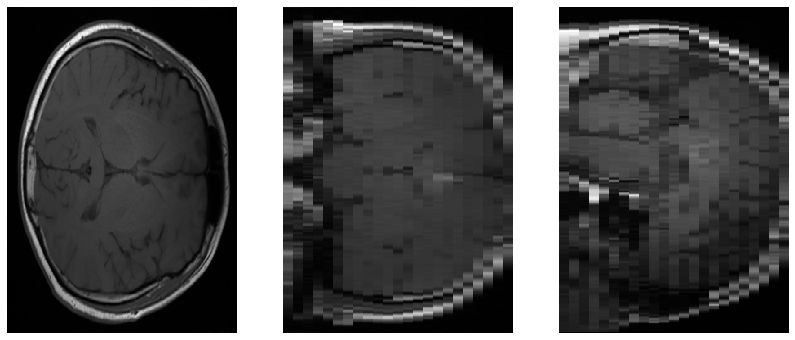

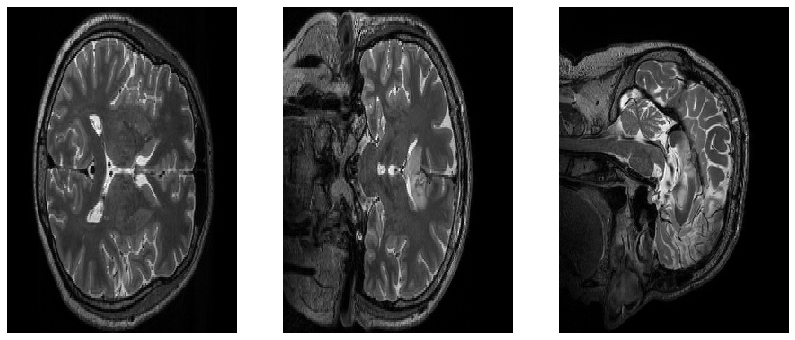

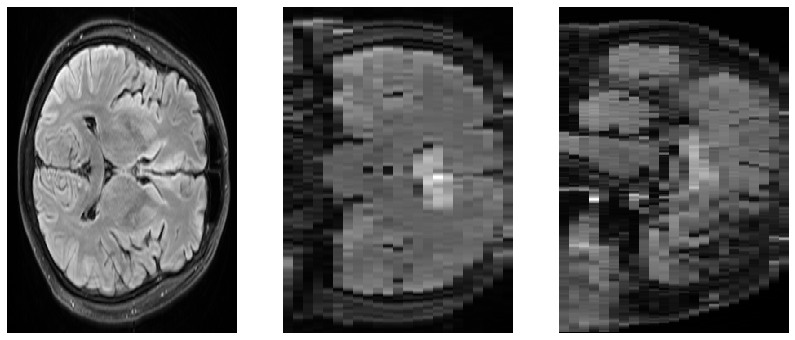

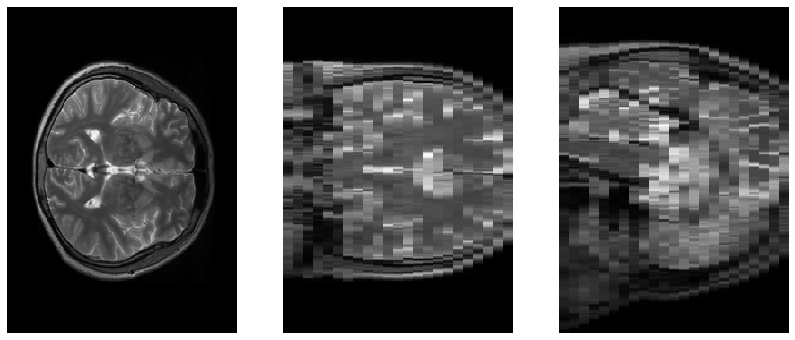

In [5]:
# show UniRes input
_ = [show_image(x[i], fig_num=i) for i in range(len(x))]

In [6]:
# as the T2w are of the same sequence (repeats), we here combine these as input to UniRes
x = [x[0], [x[1], x[3]], x[2]]

In [7]:
# 1. run UniRes with trilinear reslice
s = settings()
s.prefix = 'l' + s.prefix
s.max_iter = 0  # setting the number of iterations to zero makes UniRes use trilinear reslice (instead of super-res)
s.common_output = True  # ensures 'standardised' outputs across subjects
_, _, y_hat = preproc(x, sett=s)


  _   _       _ ____           
 | | | |_ __ (_)  _ \ ___  ___ 
 | | | | '_ \| | |_) / _ \/ __|
 | |_| | | | | |  _ <  __/\__ \
  \___/|_| |_|_|_| \_\___||___/

26/03/2021 10:11:39 | GPU: Quadro RTX 8000, CUDA: True, PyTorch: 1.7.1

Input
c=0, n=0 | fname=./data/mri0.nii
c=1, n=0 | fname=./data/mri1.nii
c=1, n=1 | fname=./data/mri3.nii
c=2, n=0 | fname=./data/mri2.nii

Performing multi-channel (N=4) alignment...completed in 8.47132 seconds.

Performing rigid+scale atlas alignment...completed in 39.42901 seconds.

Mean space | dim=(192, 256, 192), vx=(1.0, 1.0, 1.0)


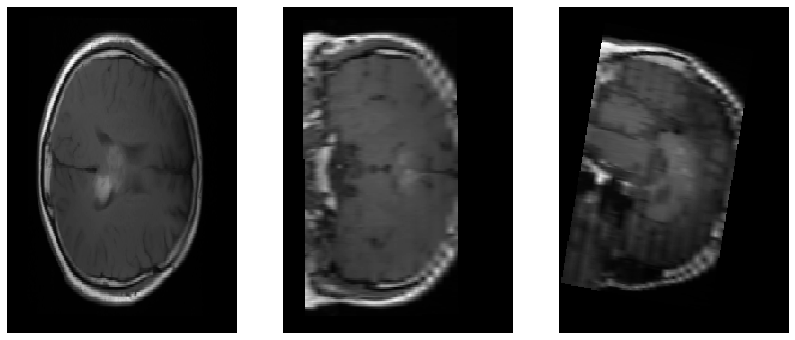

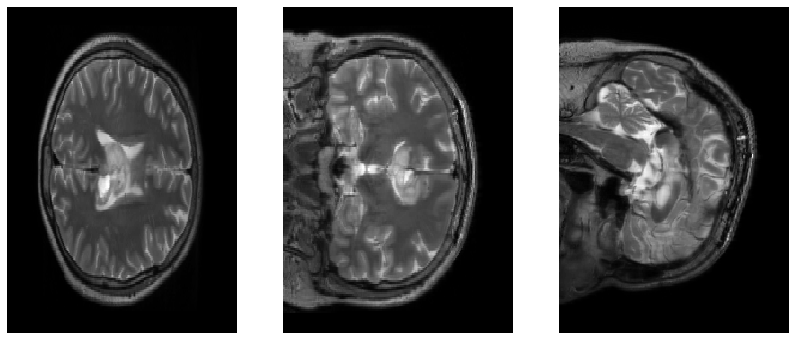

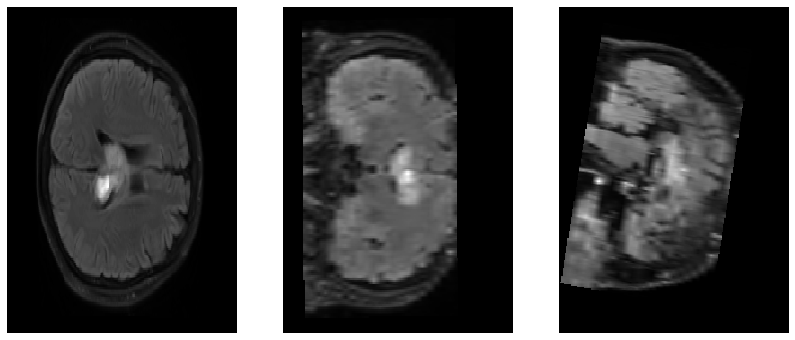

In [8]:
# show UniRes trilinear reslice output
_ = [show_image(y_hat[i], fig_num=i) for i in range(len(y_hat))]

In [9]:
# 2. run UniRes with unified super-resolution
s = settings()
s.common_output = True  # ensures 'standardised' outputs across subjects
_, _, y_hat = preproc(x, sett=s)


  _   _       _ ____           
 | | | |_ __ (_)  _ \ ___  ___ 
 | | | | '_ \| | |_) / _ \/ __|
 | |_| | | | | |  _ <  __/\__ \
  \___/|_| |_|_|_| \_\___||___/

26/03/2021 10:12:29 | GPU: Quadro RTX 8000, CUDA: True, PyTorch: 1.7.1

Input
c=0, n=0 | fname=./data/mri0.nii
c=1, n=0 | fname=./data/mri1.nii
c=1, n=1 | fname=./data/mri3.nii
c=2, n=0 | fname=./data/mri2.nii

Estimating model hyper-parameters... completed in 0.65757 seconds:
c=0 | tau=   0.03099 | sd=     5.681 | mu=     372.9 | ct=False 
c=1 | tau=    0.3131     0.1803 | sd=     1.787      2.355 | mu=     105.1      109.1 | ct=False False 
c=2 | tau=   0.03765 | sd=     5.153 | mu=     250.4 | ct=False 

Performing multi-channel (N=4) alignment...completed in 7.94991 seconds.

Performing rigid+scale atlas alignment...completed in 39.30638 seconds.

Mean space | dim=(192, 256, 192), vx=(1.0, 1.0, 1.0)

ADMM step-size=24.3262

Starting super-resolution (update_rigid=True, update_scaling=True) 
 | C=3 | N=4 | device=cuda | max

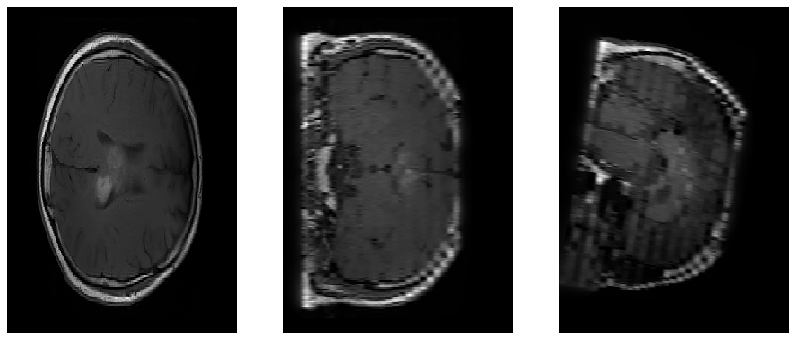

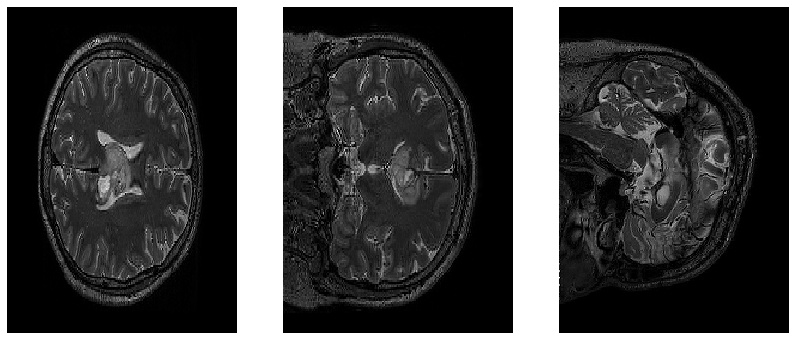

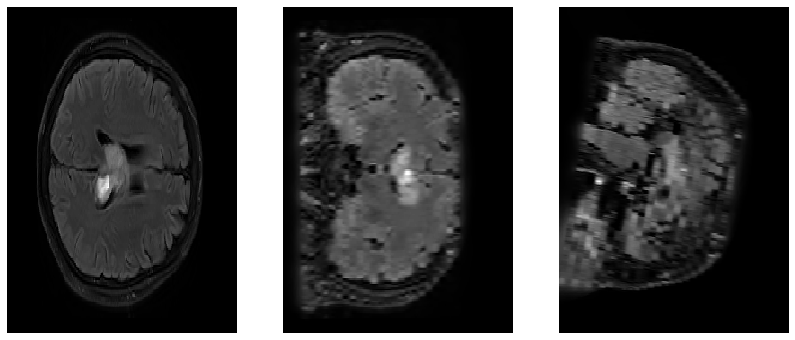

In [10]:
# show UniRes unified super-resolution output
_ = [show_image(y_hat[i], fig_num=i) for i in range(len(y_hat))]